In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.datasets import fetch_openml

In [6]:
mnist = fetch_openml('mnist_784')
mnist.data.shape, mnist.target.shape
x_data = mnist.data
y_data = mnist.target.astype(int)

In [7]:
from sklearn.model_selection import train_test_split
import torch
import torchvision

device = 'cpu'
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
X_train, X_test = torch.Tensor(X_train.values), torch.Tensor(X_test.values)
y_train, y_test = torch.Tensor(y_train.values), torch.Tensor(y_test.values)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([56000, 784])
torch.Size([14000, 784])
torch.Size([56000])
torch.Size([14000])


### Model 
- model(주로 신경망)의 구조를 선언하는 부분
- __init__, forward 부분이 필요함
- torch.nn.Linear / torch.sigmoid

In [8]:
# LogisticRegression Model
import torch.nn as nn
class LogisticRegression(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)
  def forward(self, x):
    outputs = torch.sigmoid(self.linear(x))
    return outputs

In [9]:
m = nn.Linear(20, 30) # 20짜리 input 받아서 30 dim 짜리 output 만들어주는 -> 20 x 30 = 600개 파라미터 필요 
input = torch.randn(128, 20) 
output = m(input)
print(output.shape)
print(m.weight.shape)

torch.Size([128, 30])
torch.Size([30, 20])


## y = xAT + b
- x : input / AT : 파라미터 
- input x parameter = 한 데이터에 대해서 128행 20열짜리 매트릭스 나옴
  * 그럼 한 벡터가 데이터가 된다 근데 Transpose 했으므로 
     (AT는 20행 30열 매트릭스가 됨) -> 강의 다시 들어봐야할 듯


< torch.nn.Linear의 역할 = fully connected layer >
- 원래 20dim(열) 짜리 input 128개가 있었는데 20 x 30 매트릭스(파라미터)를 곱해서 transpose를 해주니까 30 dim을 갖는 128짜리 데이터로 데이터가 transformation 되었다. 


### Training 관련 hyper parameter 결정
- loss를 줄이는 방향으로(parameter) 
- 모델 외 에폭, 학습률 같은 변수 (hyper parameter)

In [14]:
# hyper parameter 
epochs = 1000
input_dim = 784
output_dim = 10
lr = 0.001

model = LogisticRegression(input_dim, output_dim)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Training and Test

In [15]:
loss_save_arr = []
for i in range(epochs):
  ## train ##
  model.train()
  optimizer.zero_grad()
  output = model(X_train)
  loss = criterion(output, y_train.long())
  #l2_lambda = 0.001
  #l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
  #loss = loss + l2_lambda * l2_norm
  loss.backward()
  optimizer.step()
  loss_save_arr.append(loss.data)
  if(i%100==0):
    print("=====")
    print('epoch', i)
    print('loss', loss.data)
    _, pred = torch.max(output.data, axis=1)
    print("train_accuracy {:0.3f}".format(float((pred==y_train).sum())/y_train.size(0)))
    ### test ###
    model.eval()
    with torch.no_grad():
      output = model(X_test)
      _, pred = torch.max(output.data, axis=1)
      print("train_accuracy {:0.3f}".format(float((pred==y_test).sum())/y_test.size(0)))

=====
epoch 0
loss tensor(2.3618)
train_accuracy 0.061
train_accuracy 0.059
=====
epoch 100
loss tensor(1.9536)
train_accuracy 0.327
train_accuracy 0.326
=====
epoch 200
loss tensor(1.8379)
train_accuracy 0.523
train_accuracy 0.519
=====
epoch 300
loss tensor(1.7903)
train_accuracy 0.613
train_accuracy 0.610
=====
epoch 400
loss tensor(1.7637)
train_accuracy 0.657
train_accuracy 0.653
=====
epoch 500
loss tensor(1.7471)
train_accuracy 0.680
train_accuracy 0.678
=====
epoch 600
loss tensor(1.7354)
train_accuracy 0.695
train_accuracy 0.696
=====
epoch 700
loss tensor(1.7269)
train_accuracy 0.705
train_accuracy 0.705
=====
epoch 800
loss tensor(1.7195)
train_accuracy 0.713
train_accuracy 0.712
=====
epoch 900
loss tensor(1.7133)
train_accuracy 0.721
train_accuracy 0.719


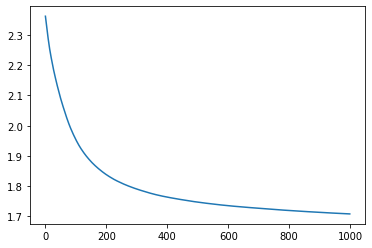

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epochs), [e.to("cpu") for e in loss_save_arr])

## 정확도를 높이려면? 

In [17]:
loss_save_arr = []
for i in range(epochs):
  ## train ##
  model.train()
  optimizer.zero_grad()
  output = model(X_train)
  loss = criterion(output, y_train.long())
  l2_lambda = 0.001
  l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
  loss = loss + l2_lambda * l2_norm
  loss.backward()
  optimizer.step()
  loss_save_arr.append(loss.data)
  if(i%100==0):
    print("=====")
    print('epoch', i)
    print('loss', loss.data)
    _, pred = torch.max(output.data, axis=1)
    print("train_accuracy {:0.3f}".format(float((pred==y_train).sum())/y_train.size(0)))
    ### test ###
    model.eval()
    with torch.no_grad():
      output = model(X_test)
      _, pred = torch.max(output.data, axis=1)
      print("train_accuracy {:0.3f}".format(float((pred==y_test).sum())/y_test.size(0)))

=====
epoch 0
loss tensor(1.7115)
train_accuracy 0.726
train_accuracy 0.726
=====
epoch 100
loss tensor(1.7073)
train_accuracy 0.730
train_accuracy 0.730
=====
epoch 200
loss tensor(1.7038)
train_accuracy 0.734
train_accuracy 0.732
=====
epoch 300
loss tensor(1.7007)
train_accuracy 0.737
train_accuracy 0.735
=====
epoch 400
loss tensor(1.6980)
train_accuracy 0.740
train_accuracy 0.738
=====
epoch 500
loss tensor(1.6954)
train_accuracy 0.742
train_accuracy 0.740
=====
epoch 600
loss tensor(1.6931)
train_accuracy 0.744
train_accuracy 0.743
=====
epoch 700
loss tensor(1.6912)
train_accuracy 0.746
train_accuracy 0.745
=====
epoch 800
loss tensor(1.6895)
train_accuracy 0.747
train_accuracy 0.747
=====
epoch 900
loss tensor(1.6879)
train_accuracy 0.749
train_accuracy 0.748
